# Applied Micro Study Group: Computation
*Apr 23, 2019*

*Mauro Moretto, Faith Feng*

## Overview:
1. Improve your workflow with JupyterLab, some coding tips
2. Simulate data of the single agent job search model based on *Application 1: Search Model* in *Nonstationary Dynamic Models with Finite Dependence* (Arcidiacono and Miller, 2019)
3. Estimation with CCP 

## 1. JupyterLab: Smoothing Your Workflow

- JupyterLab is an augmentation of the very popular Jupyter Notebook which supports over 40 programming languages such as Python, R, Julia.

- Like Jupyter Notebook, one can keep the comments and notes together with your codes. One can display the results of your code cleanly as well.

- So it is very good for developing codes since you can record your ideas and experiment your codes at the same place.

- However, Jupyter Notebook (file type *.ipynb* instead of *.py*) is slower than compiling Python (*.py*) codes in terminal, so people usually just use it to experiment ideas, keep records of code development or presenting codes.

- With JupyterLab, one can transfer the codes easily to traditional Python files and compile in terminals.

### Good code styles can help you in the long-run

It is generally good pratice to:

- __name your variables and functions well__ Don't be lazy to write short abbreviations of names that are hard to understand)  
- __avoid magic numbers__ (unique values with unexplained meaning or multiple occurrences which could be replaced with named constants) to clarify meaning, so that other people (including yourself after not working on the project for a while) can quickly understand what's going on.  
- __avoid copy-pasting your code__ Instead, write functions or classes with changeable parameters.  
- __minimize the usage of global variables__ They can be really messy in a medium or large sized project, as they can easily affect what happens in your code. And at the same time, they can be modified by any part of your program. See *Global variables are BAD* (http://wiki.c2.com/?GlobalVariablesAreBad)

### Why Python is not that bad?

1. Community support:

| Language| Registered Packages | GitHub Projects | Reddit | Job Postings |
| :---   |     :---:           |     :---:       | :---:  |    :---:    |
| Python | 176,369             |    2,182,259    | 350k   | 30,328      |
| R      | 14,094              |      561,434    | 13.5k  | 8,563       |
| Julia  | over 2,400          |       16,394    | 6.5k   | 203         |
Data Sources:
*Registered packages: Pypi.org (Python), R-CRAN (R), Julialang (Julia)  
*GitHub projects: from GHTorrent data collected in 2018  
*Reddit: members of subreddits r/Python, r/Rlanguage and r/Julia  
*Job posting: search by "language programming" (language=Python, R, Julia) on Indeed.com (Apr 17, 2019)  

2. Speed:
Python is slow compared to low-level languages like C/C++, Java .etc for mainly 2 reasons:
    - It is interpreted rather than compiled (it translates higher level languages into lower-level/faster languages). Common problem for all high-level languages.
    - Global Interpreter Lock (GIL): prevents multi-threading, but it greatly simplifies programming complexity faced by developers.

However, there are ways to boost the performance (such as multi-processing instead of multi-threading). And it is important to keep in mind that, most of the times, especially for not so professionally trained programmers (such as myself), the greatest restriction on the performance is the underlying algorithm of the program that one writes.

*Yes, the performance matters. But the user/developer experience also matters. Python is known for being simple to program, easy to read and maintain.*

__Conclusion: Don't use Python to program fancy video games. But for most of data analysis purposes, it is not necessarily low-performing, and it has much more community supports.__

## 2. Data Simulation

### A Simple Job Search Model

- Each period $t \in \{1, \cdots, T\}$, an individual may stay home ($d_{1t} = 1$) or apply for temporary employment setting ($d_{2t}=1$). 

- Job applicants are successful with probability $\lambda_{t}$, and the value of the position depends on the experience of the individual denoted by $x \in \{1, \cdots, X\}$. 
$$\lambda_{t} = 0.5\frac{x_t}{(T-1)}+0.5, ~~ x_t \in \{0, \cdots, T-1\}$$

- If the individual works his experience increases by one unit, and remains at the current level otherwise.

- The preference primitives are given by the current utility from staying home, denoted by $u_{1}(x_t) $, and the utility of working $u_2(x_t)$.
$$u_{1}(x_t) = 0, ~~u_{2}(x_t) = \frac{x_t^{1-\eta}}{1-\eta}$$

### A touch of software engineering: Top-Down v.s. Bottom-Up Design

- Top-Down: Write the big framework first, then fill in the smaller functions that the big framework needs.

    *advantage*: no need to think about every little details of implementation first; it can help you figure out what kind of supporting functions you need, and makes project management easier.

    *disadvantage*: no coding can start until there is a thorough understanding of the entire structure of the project.

- Bottom-Up: Write the smaller elements first, then write the big framework.

    *advantage*: it is easier to test the smaller functions as soon as you create them
    
    *disadvantage*: it is usually easier to lose track of the big framework in which the small functions operate, and may lead to a non-optimized implementation of such functions

In [1]:
import numpy as np
import pandas as pd
import functools, itertools
import os, time, random
import matplotlib.pyplot as plt
import scipy.optimize as sop

### Compute Expected Maximum of Two Random Variables

Here we have a special case of a constant plus a TIEV random variable. So we can just generate a big list of TIEV random numbers, add the constant, and then take an average.

In [2]:
def expectedMax(*args, mu=0, beta=1, size=2000):
    # compute Emax[val1+epsilon1, val2+epsilon2]
    np.random.seed(100)
    total_values = [args[i]+np.random.gumbel(mu, beta, size) for i in range(len(args))]
    return np.average([max(x) for x in zip(*total_values)])

## test case
start = time.time()
x2 = []
i=0
while i<=1:
    x2 += [expectedMax(0, 2, mu=0, beta=1, size=5000)]
    i += 1
print(np.mean(x2), np.std(x2))
print(time.time()-start)

2.7165207382078775 0.0
0.013010501861572266


### Compute Future/Continuation Value

Let the conditional choice value be:
$$ v_{jt}(x_t) = u_{jt}(x_t) + \delta E[V_{t+1}(x_{t+1}) | x_{t}, j]$$
Here we're computing the second part of the total conditional value, where:
$$
E[V_{t+1}(x_{t+1}) | x_{t}, j] = E_{x_{t+1}, \epsilon_{1t+1},\epsilon_{2t+1}}\left[\max\left\{ u_{1t+1}(x_{t+1}) + \epsilon_{1t+1} + \delta E[V(x_{t+2})|x_{t+1}, j=1], \\
u_{2t+1}(x_{t+1}) + \epsilon_{2t+1} + \delta E[V(x_{t+2})|x_{t+1}, j=2]\right\} |~x_t, j \right]
$$

The transition of state variable $x_t$:
$$
F(x_{t+1} = x_t |x_t, j=1) = 1 \\
F(x_{t+1} = x_t |x_t, j=2) = 1-\lambda_{t} \\
F(x_{t+1} = x_t+1 |x_t, j=2) = \lambda_{t}
$$

So with current work experience $x_t$, if the current choice is $d_t=1$, the work experience next period $x_{t+1}$ is $x_t$ for sure. The continuation value at $t$ is $V(x_t)$.
But if $d_t=2$, the work experience next period can be $x_t$ or $x_t+1$. The continuation value at $t$ is $\lambda_t V(x_t+1)+(1-\lambda_t) V(x_t)$.

### A bit more coding trick:

- Python allows recursive functions.
- Recursive functions are sometimes easier to write and to read when the problem is recursive in nature (such as the classical Fibonacci function) than traditional iterations (for/while loops), but it's usually __much__ slower in Python.
- However, one can improve the performance of recursion greatly in Python using "memoization".
- Memoization means that we tell the program to memorize the "intermediate" results to avoid unnecessary calculations by keeping a "memo" of previous calculated results.

In [9]:
## success rate of job application
success = lambda work_experience, T=10: (work_experience/(T-1))*0.5+0.5
successRates = [success(x) for x in range(10)]

In [15]:
def dataSimulationIteration(successRates, theta, discount, N=1000, T=10):
    N_sim = 2000
    utilityWork = [-np.exp(-theta*x)+0.5 for x in range(0,T)]
    utilityHome = [0]*T
    # no need to allocate space to store
    continuation_value = np.zeros((T+1,T+1))
    epsilon_work = np.random.gumbel(0,1,size = N_sim)
    epsilon_home = np.random.gumbel(0,1,size = N_sim)
    success_shock_sim = np.random.random(size = N_sim)   

    for age in range(T-1, -1, -1): 
        for exp in range(age, -1, -1):              
            success_rate = successRates[exp]
            success_sim = np.zeros((N_sim,))
            success_sim[success_shock_sim <= success_rate] = 1
            value_hw = np.zeros((N_sim,2))
            value_hw[:,0] = (utilityHome[exp] + epsilon_home + discount*continuation_value[age+1,exp])
            value_hw[:,1] = epsilon_work + success_sim*(utilityWork[exp] + discount*continuation_value[age+1,exp+1]) + (
                1-success_sim)*(utilityHome[exp] + discount*continuation_value[age+1,exp])
            
            continuation_value[age,exp] = np.mean(np.max(value_hw,axis=1))
    
    def individualSimulation(i):  
        nonlocal T, successRates, continuation_value
        epsilon_work_i = np.random.gumbel(0,1,size = T)
        epsilon_home_i = np.random.gumbel(0,1,size = T)
        success_shock_sim = np.random.random(size=T)   
        
        exp_i = np.zeros((T,),dtype = int)
        choice_i = np.zeros((T,),dtype = int)
        
        for age in range(T):            
            success_rate = successRates[exp_i[age]]
            value_home = (utilityHome[exp_i[age]] + epsilon_home_i[age] + discount*continuation_value[age+1,exp_i[age]])
            value_work = (epsilon_work_i[age] + success_rate*(utilityWork[exp_i[age]] + discount*continuation_value[age+1,exp_i[age]+1]) + (1-success_rate)*(utilityHome[exp_i[age]] + discount*continuation_value[age+1,exp_i[age]]))
            choice_i[age] = 1 + int(value_home <= value_work)
            if (age < T-1):
                    exp_i[age+1] = exp_i[age] + (choice_i[age] == 2) *(
                        success_shock_sim[age] <= success_rate) 
            
        matrix_sim_i = np.zeros((T,4),dtype = int)
        matrix_sim_i[:,0] = i*np.ones((T,))
        matrix_sim_i[:,1] = choice_i
        matrix_sim_i[:,2] = exp_i
        matrix_sim_i[:,3] = range(0,T)    
        
        return matrix_sim_i
    
    matrix_sim = np.zeros((N*T,4))     
    
    for i in range(0,N):
        
        matrix_sim[i*T:(i+1)*T,:] = individualSimulation(i)
        
    df_sim = pd.DataFrame(matrix_sim, columns=["individual", "choice", "experience", "age"],dtype = int)
            
    return df_sim

start = time.time()    
bla = dataSimulationIteration(successRates, 2, 0.9)
bla.to_pickle('bla_simulation_search_data.pkl')
end = time.time()
print(end-start)
print(bla.head())

0.131943941116333
   individual  choice  experience  age
0           0       2           0    0
1           0       2           0    1
2           0       1           0    2
3           0       2           0    3
4           0       1           0    4


In [ ]:
# decorator function: function that takes another function as argument
def memoize(function):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = function(x)
        return memo[x]
    return helper

def saveData(res, T, N):
    individuals = list(itertools.chain(*[[i]*T for i in range(N)]))
    time_periods = list(itertools.chain(*[list(range(T)) for i in range(N)]))
    work_experiences = list(itertools.chain(*[item[0] for item in res]))
    choices = list(itertools.chain(*[item[1] for item in res]))
    data = pd.DataFrame({'individual': individuals, 'age': time_periods, 
                         'work_experience': work_experiences, 'choice': choices})
    return data

In [129]:
# simulate data given the parameter
def dataSimulationRecursion(successRates, theta, discount, N=1000, T=10):
    # successRates should be a list or array that can be sliced by index
    utilityWork = [-np.exp(-theta*x)+0.5 for x in range(0,T)]
    utilityHome = [0]*T
    @memoize
    def continuationValue(arg_tuple):
        nonlocal discount, successRates
        t, T, work_experience, current_choice = arg_tuple
        if t>=T-1:
            return 0
        else:
            success_rate = successRates[work_experience]
            state_tuple_home = (t+1, T, work_experience, 1)
            value_home = (utilityHome[work_experience]+
                             continuationValue(state_tuple_home))
            state_tuple_work = (t+1, T, work_experience, 2)
            value_work = (utilityWork[work_experience]+
                             continuationValue(state_tuple_work))
            if current_choice==1:
                # now home -> state variable next period stays the same
                continuation_value = discount*expectedMax(value_home, value_work)
            else:
                # now work -> state variable next period may change
                # if job application succeeds
                state_tuple_home_success = (t+1, T, work_experience+1, 1)
                value_home_success = (utilityHome[work_experience+1]+
                             continuationValue(state_tuple_home_success))
                # if job application fails
                state_tuple_work_success = (t+1, T, work_experience+1, 2)
                value_work_success = (utilityWork[work_experience+1]+
                             continuationValue(state_tuple_work_success))
                # total continuation value
                continuation_value = discount*(
                    success_rate*expectedMax(value_home_success, value_work_success)+
                    (1-success_rate)*expectedMax(value_home, value_work))
            return continuation_value
        
    def generateChoices(T, successRates, discount, mu=0, beta=1):
        # default mu and beta -> type I extreme value
        work_experience = 0
        work_experiences = [work_experience]
        choices = []
        actual_shock_home = np.random.gumbel(mu, beta, T)
        actual_shock_work = np.random.gumbel(mu, beta, T)
        t = 0
        while t<=T-1:
            success_rate = successRates[work_experience]
            job_search = random.random()
            state_tuple_home = (t, T, work_experience, 1)
            state_tuple_work = (t, T, work_experience, 2)
            value_home = (utilityHome[work_experience]+actual_shock_home[t]+
                          discount*continuationValue(state_tuple_home))
            value_work = (actual_shock_work[t]+success_rate*utilityWork[work_experience]+
                          (1-success_rate)*utilityHome[work_experience]+
                          discount*continuationValue(state_tuple_work))
            choices += [1+(value_home<=value_work)]
            if t<T-1:
                work_experience += (job_search<=success_rate)*(value_home<=value_work)
                work_experiences += [work_experience]
            t += 1
        return work_experiences, choices
    res = [generateChoices(T, successRates, discount) for i in range(N)]
    data = saveData(res, T, N)
    return data

start = time.time()
data = dataSimulationRecursion(successRates, 2, 0.9)
data.to_pickle('simulation_search_data.pkl')
print(time.time()-start)
print(data.head())

0.1379246711730957
   individual  choice  experience  age
0           0       2           0    0
1           0       1           1    1
2           0       2           1    2
3           0       2           2    3
4           0       2           3    4
0.29183220863342285
   age  choice  individual  work_experience
0    0       1           0                0
1    1       2           0                0
2    2       2           0                0
3    3       1           0                0
4    4       2           0                0


## 2. Estimation Using Data
General idea: minimizing the distance between simulated choice probabilities and empirical choice probabilities. (*Related lecture notes: http://www.its.caltech.edu/~mshum/gradio/single-dynamics2.pdf*)

Procedure:
1. Estimate conditional choice probability $\hat{P}(d|X)$
2. Estimate transition probability (job search success rate)
3. Simulate value functions, generate model choice probability $\tilde{P}(d|X, \theta)$
4. Estimate by minimum distance 
$$ \min_{{\theta}}\left|\left|\mathbf{\tilde{P}}(d|X, \theta)-\mathbf{\hat{P}}(d|X)\right|\right|^2_2$$

Note: To see more computation implementation of other methods (MPEC, NFP, .etc), I recommend Professor Param Vir Singh's class *PhD Seminar on Estimating Dynamic and Structural Models*. The course is taught in Matlab, but you're free to do the assignments in whatever language you like.

In [5]:
# load data and lag the data to get future work experience
data = pd.read_pickle('simulation_search_data.pkl')
data['future_work_experience'] = data['work_experience'].shift(-1).values.astype(int)
T = 10
mask = data.age == T-1
data.loc[mask,'future_work_experience'] = 999

Now, we we want to estimate the condtional choice probabilities. Given that the problem is non-stationary, we need to compute:
$$\hat{p}(d = 2|x,t)= \frac{\sum_{i=1}^N \mathbf{1}  \left( x_{it} = x, d_{it} = 2 \right)}{\sum_{i=1}^N \mathbf{1} \left( x_{it} = x \right)}$$
Now, it may be the case that for certain combinations of $(x,t)$, we do not have any observation.

In our simulation, all agents are born in period $t=0$, and have no experience, so that 
$$x_{i0}=0 \ \forall i=1,\cdots,N$$

This also implies that in the data we will not observe $x_{it}>t$ for any agent $i$. If we define 
$$\mathbf{\hat{P}}=[\hat{p}_{ij}] = [\hat{p}(d =2 | t=i,x=j)]$$
then we should expect $\hat{\mathbf{P}}$ to be defined only in its lower-triangular portion. 

In [73]:
def ccp_fun_inefficient(data):

    ccp = np.zeros((T,T))
    W = np.zeros((T,T))
    for age in range(0,T):
        for exp in range(0,T):
            num = len(data[(data['age'] == age) & (data['work_experience'] == exp) & (data['choice'] == 2) ])
            den = len(data[(data['age'] == age) & (data['work_experience'] == exp)]) 
            W[age,exp] = den
            if den == 0:
                ccp[age,exp] = np.nan
            else:
                ccp[age,exp] = num/den
        
    ccp_vec = ccp[np.tril_indices(T)]
    W = W[np.tril_indices(T)]/np.sum(W)
    ccp_vec[np.isnan(ccp_vec)] = 999
    
    return ccp_vec, W

start = time.time()
data = pd.read_pickle('simulation_search_data.pkl')
actual_ccp,actual_W = ccp_fun_inefficient(data)
print("Computation time, very inefficient code: {}: ".format(time.time()-start))

def ccp_fun(data):
    
    def ccp_state_fun(arg):
        age , exp =  arg
        mask_den = (data['age'] == age) & (data['work_experience'] == exp)
        mask_num = (mask_den) & (data['choice'] == 2) 
        W_state = np.sum(mask_den)
        ccp_state = np.sum(mask_num) / W_state if W_state>0 else 999
        return ccp_state,W_state
       
    output = [ccp_state_fun(item) for item in filter(lambda x: x[0]>=x[1], itertools.product(range(0,T),range(0,T)))]
    ccp = np.array([item[0] for item in output])
    W = np.array([item[1] for item in output])
    W = W / np.sum(W)
    
    return ccp , W
    
 
start_time = time.time()
data = pd.read_pickle('simulation_search_data.pkl')
actual_ccp,actual_W = ccp_fun(data)
print("Computation time, less inefficient code: {}: ".format(time.time()-start_time))


Computation time, very inefficient code: 0.23186635971069336: 
Computation time, less inefficient code: 0.08295178413391113: 


Now we want to estimate the probability of job acceptance conditional on the level of experience accumulated over the working life: 
$$\hat{\lambda} (x)  = \frac{\sum_{i=1}^N \sum_{t=0}^{T-1} \mathbf{1} \left( x_{it}=x, x_{it+1} = x + 1, d_{it}=2  \right)}{\sum_{i=1}^N \sum_{t=0}^{T-1} \mathbf{1} \left( x_{it}=x, d_{it}=2  \right)}  $$

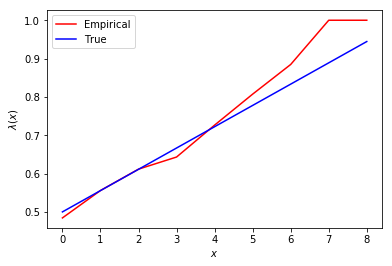

In [74]:
# estimation transition probability/success rate
def p_acpt_fun(data):

    data['future_work_experience'] = data['work_experience'].shift(-1).values.astype(int)
    mask = data.age == T-1
    data.loc[mask,'future_work_experience'] = 999
    
    p_acpt = np.zeros((T-1,))
    for i in range(0,T-1):
        num = np.sum((data['age'] < T-1) & (data['work_experience'] == i) & (data['future_work_experience'] == i + 1) & (data['choice'] == 2))
        den = np.sum((data['age'] < T-1) & (data['work_experience'] == i) & (data['choice'] == 2)) 
        if den > 0:
            p_acpt[i] = num / den
        else:
            p_acpt[i] = np.nan

    return p_acpt

data = pd.read_pickle('simulation_search_data.pkl')
success_rates = p_acpt_fun(data)

plt.figure()
plt.plot(range(0,9),success_rates,'r',label='Empirical')
plt.plot(range(0,9),[0.5 + 0.5/(T-1) * item for item in range(0,9)],'b',label = 'True')
plt.xlabel(r'$x$')
plt.ylabel(r'$\lambda(x)$')
plt.legend()
plt.show()


In [82]:
# minimizing distance between predicted CCP and actual CCP

def predictCCP(success_rates, theta, discount):
    data = dataSimulation(successRates, theta, discount)
    ccp, W = ccp_fun(data)
    return ccp, W

def estimator(parameters):
    global actual_ccp, success_rate
    theta = parameters[0]
    discount = parameters[1]
    predicted_ccp, W = predictCCP(success_rates, theta, discount)
    distance = np.sum(np.multiply((predicted_ccp-actual_ccp)**2,W))
    return distance

theta_vec = np.linspace(1.1,2.9,20)
discount_vec = np.linspace(0.5,1,20)
obj = [estimator(item) for item in itertools.product(theta_vec,discount_vec)]



In [83]:
y = list(itertools.product(theta_vec,discount_vec))
smallest_ten = sorted(obj)[0:10]
objective = list(zip(obj, y))
objective = dict(objective)
print([objective[x] for x in smallest_ten])
print(smallest_ten)

[(2.0473684210526315, 0.8947368421052632), (1.5736842105263158, 0.9473684210526315), (1.763157894736842, 0.9473684210526315), (2.236842105263158, 0.8947368421052632), (2.4263157894736844, 0.8947368421052632), (1.3842105263157896, 0.9473684210526315), (2.6157894736842104, 0.8947368421052632), (2.1421052631578945, 0.8421052631578947), (2.1421052631578945, 0.8947368421052632), (1.5736842105263158, 0.9210526315789473)]
[0.00095397149582135, 0.0011454438392347558, 0.0011861003654897921, 0.0012368233151483178, 0.001265058498162237, 0.0012915357806275935, 0.0013109378396400086, 0.0013490009446168755, 0.0013565565800431163, 0.001378606931259905]


In [ ]:
estimated_parameters = sop.minimize(estimator2, x0=(1.1, 0.9), method='powell')

In [ ]:
tuple(estimated_parameters['x'])

In [ ]:
print(sop.minimize(estimator2, x0=tuple(estimated_parameters['x']), method='powell'))

In [ ]:
print(sop.minimize(estimator2, x0=(8.06984256, 0.83932741), method='powell'))

In [ ]:
np.where(np.array(obj)==min(obj))[0][0]

In [ ]:
# obj[77]
list(itertools.product(theta_vec,discount_vec))[77]

In [ ]:
from mpl_toolkits import mplot3d
theta_vec1 = [item[0] for item in itertools.product(theta_vec,discount_vec)]
discount_vec1 = [item[1] for item in itertools.product(theta_vec,discount_vec)]
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(theta_vec1, discount_vec1, obj, 'gray')
plt.show()

In [78]:
from multiprocessing import Pool, cpu_count

if __name__ ==  '__main__': #this is the only additional line
    num_processors = cpu_count()
    p=Pool(processes = num_processors)
    output = p.map(estimator2,itertools.product(theta_vec,discount_vec))
    print(output)

PicklingError: Can't pickle <function <lambda> at 0x0000024CEA757D08>: attribute lookup <lambda> on __main__ failed

In [80]:
print(actual_ccp)

[0.589      0.6022567  0.61168385 0.57114625 0.53608247 0.55660377
 0.56200528 0.5519802  0.625      0.53658537 0.6        0.54320988
 0.56888889 0.57303371 0.4375     0.54450262 0.58855586 0.62890625
 0.59124088 0.62790698 0.66666667 0.52941176 0.55709343 0.54639175
 0.55913978 0.61842105 0.77777778 0.75       0.4953271  0.57268722
 0.57586207 0.55769231 0.49074074 0.57446809 0.9        0.66666667
 0.50684932 0.52406417 0.59073359 0.55737705 0.54545455 0.66666667
 0.51851852 0.5        0.5        0.50847458 0.59027778 0.56696429
 0.5755102  0.61494253 0.64367816 0.54545455 0.64705882 0.6
 0.        ]
